# This code will perform data exploration on the dataset of ACLforces

In [1]:
import os
cwd = os.getcwd()
import seaborn as sns
import pandas as pd
import numpy as np
from opensim_utils_g import readMotionFile
import matplotlib.pyplot as plt
import perform_opensim_analyses_ACL
import AssignPropertiesCustomLigament


D:\LocalDisk\Programs\WinPython-64bit-2.7.10.3\python-2.7.10.amd64\lib\site-packages\matplotlib\__init__.py:1354: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [3]:
subjects = pd.DataFrame(['Ahelaos','Amanda','Celine','CharlotteH','CharlotteV','Esther','Filip',\
           'Franceska','Guido','Jeroen'])
age = pd.DataFrame([22,21,22,21,21,22,22,25,24,22])
BW = pd.DataFrame([74.0061,57.0846,57.7982,59.5311,54.6381,59.633,86.5443,58.2059,64.3221,72.0163])
data = pd.concat((subjects,age,BW),axis=1)
columns=['Names','Age','Body weight']
data.columns=columns
length = len(subjects)

In [4]:
length

10

In [5]:
columns=['Names','Age','Body weight']
data.columns=columns
data['Body weight'].std()

10.098664948183332

In [6]:
%load_ext autoreload
%autoreload 1
%aimport opensim_utils_g
%aimport perform_opensim_analyses_ACL
%matplotlib inline

In [7]:
#for i in range(0,1):
#    name = subjects[i]
#    m = cwd+'/Data/'+name+'/'+name+'_2.osim'
#    AssignPropertiesCustomLigament.change_properies(m,cwd+'/Data/swing_model.osim')
                                                            

In [8]:
#for i in range(0,length):
#    name = subjects[i]
#    model = cwd+'/Data/'+name+'/'+name+'_2CL.osim' 
#    perform_opensim_analyses_ACL.Opensim_Analysis(model)

## Gather all data in one matrix. Different columns will be moments and rows will be acl_r (a and p) from every subject.

In [9]:
subjects = ['Ahelaos','Amanda','Celine','CharlotteH','CharlotteV','Esther','Filip',\
           'Franceska','Guido','Jeroen']
array_subj = []
for i in range(0,length):
    acl_r=[]
    joint_mom=[]
    acl_jm_kcf=[]
    array_trials=[]
    kcf = []
    name = subjects[i]
    results_dir = cwd+'/Data/'+name+'/Results'
    subj_dir = os.path.dirname(results_dir)
    """ACL data"""
    for k in range(1,4):
        events_file = pd.read_excel(subj_dir+'/'+name+'_HDR_'+str(k)+'_Events.xls')
        init_time = events_file.InitialContactTime.iloc[0]
        final_time = events_file.TimeLowestCOMX.iloc[1]
        """Load kinematics"""
        ik_header, ik_labels, ik_data = readMotionFile(results_dir+'/HDR_'+str(k)+'_IK.mot')
        ik_d = np.array(ik_data)
        time = ik_d[:,0]
        timeList = time.tolist()
        idx3 = timeList.index(init_time)
        idx4 = timeList.index(final_time)
        array3 = ik_d[idx3:idx4+1,31:34]#lumbar
        array7 = ik_d[idx3:idx4+1,7:11]
        array5 = ik_d[idx3:idx4+1,13]*-1#anterior-posterior
        array5 = array5.reshape(len(array5),1)
        array4 = ik_d[idx3:idx4+1,16]
        array4 = array4.reshape(len(array4),1)
        joint_ang = np.concatenate((array3,array7,array5,array4),axis=1)
        """Load the acl forces"""
        so_header, so_labels, so_data = readMotionFile(results_dir+'/'+name+'_2CL_HDR_'+str(k)+'_StaticOptimization_force.sto')
        idx1 = so_labels.index('aACL_R')
        idx2 = so_labels.index('pACL_R')
        aACL_R_data = np.array([row[idx1] for row in so_data])
        pACL_R_data = np.array([row[idx2] for row in so_data])
        acl_r = aACL_R_data+pACL_R_data
        acl_r = acl_r.reshape(len(acl_r),1)
        """Load the joint moments"""
        id_header, id_labels, id_data = readMotionFile(results_dir+'/HDR_'+str(k)+'_ID.sto')
        id_d = np.array(id_data)
        array1 = id_d[:,1:4]
        array2 = id_d[:,7:13]
        array6 = id_d[:,16:19]
        joint_mom= np.concatenate((array1,array2,array6),axis=1)
        """Load the knee reaction forces"""
        jra_header, jra_labels, jra_data = readMotionFile(results_dir+'/'+name+'_2CL_HDR_'+str(k)+'_JointReaction_ReactionLoads.sto')
        j_data = np.array(jra_data)
        kcf = j_data[:,19:22]
        """Concatenate the acl forces array with the joint moments array"""
        acl_jm_kcf_ja = np.concatenate((acl_r,joint_mom,kcf,joint_ang),axis=1)
        """Create the complete array for all three trials"""
        if k==1:
            array_trials = acl_jm_kcf_ja
        else:
            array_trials = np.concatenate((array_trials,acl_jm_kcf_ja),axis=0)
    """Create the array for all subjects"""
    if i==0:
        array_subj = array_trials
    else:
        array_subj = np.concatenate((array_subj,array_trials),axis=0)


In [10]:
"""Create the labels and the complete dataframe"""
str1 = id_labels[1:4]
str1.insert(0,'acl_r')
lb = str1+id_labels[7:13]+id_labels[16:19]+['KCF_X','KCF_Y','KCF_Z']+ik_labels[31:34]+ik_labels[7:11]+[ik_labels[13]]+[ik_labels[16]]
df = pd.DataFrame(array_subj,columns = lb)
df.shape

(603, 25)

In [11]:
df['acl_r'].max()

495.50690967

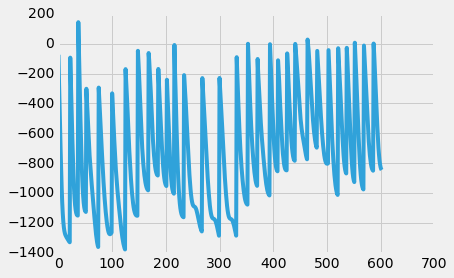

In [58]:
plt.plot(df.knee_rotation_r_moment)

## Pearson correlation heatmap

In [12]:
corr_matrix_pearson=df.corr()
corr_matrix_spearman = df.corr(method='spearman')

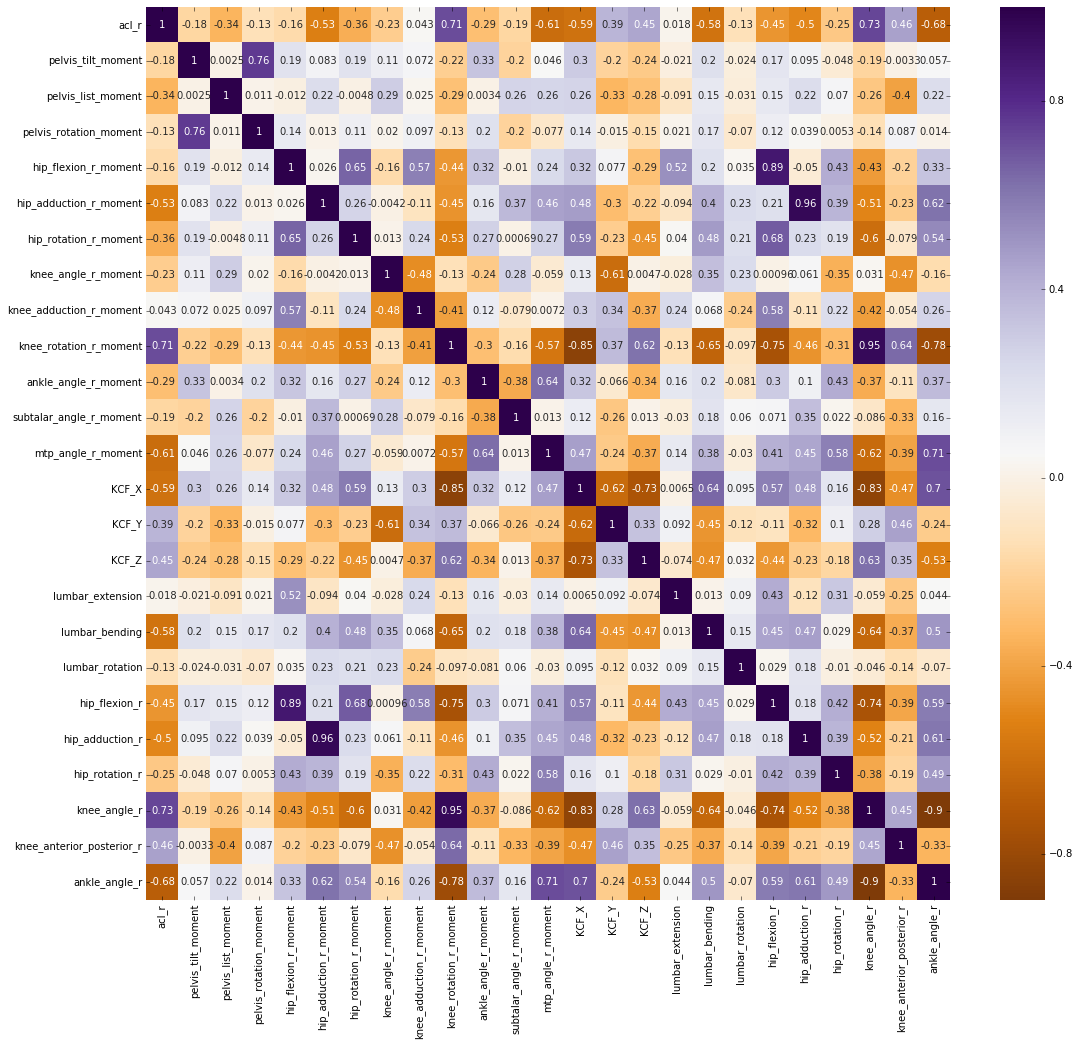

In [13]:
plt.figure(figsize=(18,16))
sns.heatmap(corr_matrix_pearson,annot=True, cmap='PuOr')

In [14]:
#Correlation with output variable
cor_target = (corr_matrix_pearson["acl_r"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.6]
relevant_features

acl_r                     1.000000
knee_rotation_r_moment    0.713632
knee_angle_r              0.730770
Name: acl_r, dtype: float64

## Spearman correlation heatmap

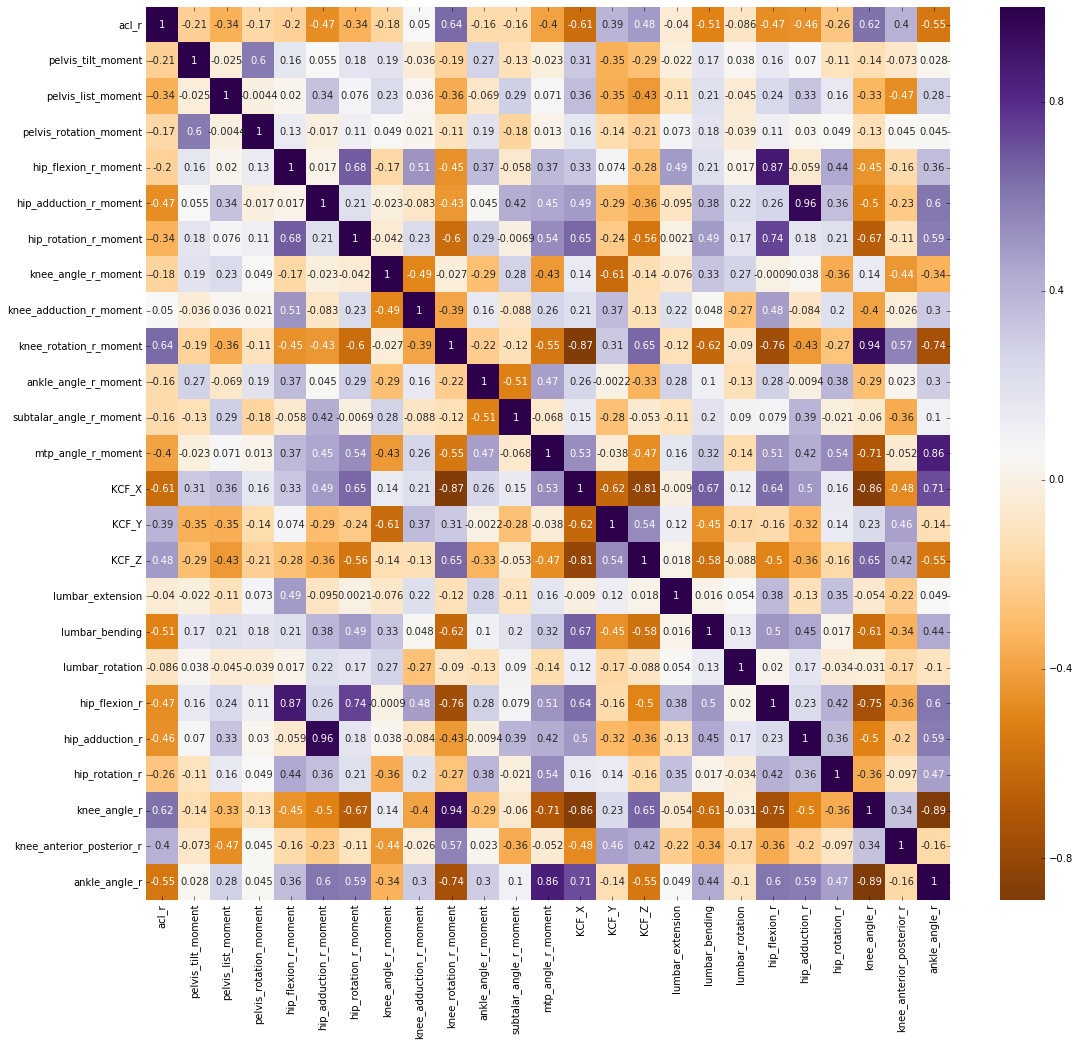

In [15]:
plt.figure(figsize=(18,16))
sns.heatmap(corr_matrix_spearman,annot=True, cmap='PuOr')

# Further data exploration

### Linear regression

In [16]:
import statsmodels.api as sm

In [17]:
y = df['acl_r']

In [18]:
X = df.drop(['acl_r'],axis=1)

In [19]:
## Without a constant

import statsmodels.api as sm

# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  acl_r   R-squared (uncentered):                   0.793
Model:                            OLS   Adj. R-squared (uncentered):              0.785
Method:                 Least Squares   F-statistic:                              92.47
Date:                Thu, 16 Jan 2020   Prob (F-statistic):                   2.47e-180
Time:                        09:02:47   Log-Likelihood:                         -3084.1
No. Observations:                 603   AIC:                                      6216.
Df Residuals:                     579   BIC:                                      6322.
Df Model:                          24                                                  
Covariance Type:            nonrobust                                                  
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
pelvis_tilt_moment           -0.0010      0.046     -0.023      0.982      -0.091       0.089
pelvis_list_moment           -0.0530      0.058     -0.918      0.359      -0.166       0.060
pelvis_rotation_moment       -0.2317      0.217     -1.066      0.287      -0.658       0.195
hip_flexion_r_moment         -0.0675      0.019     -3.587      0.000      -0.104      -0.031
hip_adduction_r_moment       -0.0754      0.010     -7.873      0.000      -0.094      -0.057
hip_rotation_r_moment         0.2155      0.056      3.834      0.000       0.105       0.326
knee_angle_r_moment          -0.0354      0.008     -4.276      0.000      -0.052      -0.019
knee_adduction_r_moment       0.0190      0.032      0.593      0.554      -0.044       0.082
knee_rotation_r_moment        0.0309      0.039      0.787      0.431      -0.046       0.108
ankle_angle_r_moment          0.1972      0.064      3.058      0.002       0.071       0.324
subtalar_angle_r_moment       0.0165      0.158      0.104      0.917      -0.294       0.327
mtp_angle_r_moment           -3.7748      0.714     -5.286      0.000      -5.177      -2.372
KCF_X                         0.0135      0.002      6.995      0.000       0.010       0.017
KCF_Y                         0.0118      0.002      5.245      0.000       0.007       0.016
KCF_Z                         0.0376      0.009      4.388      0.000       0.021       0.054
lumbar_extension             -0.2002      0.397     -0.504      0.615      -0.981       0.580
lumbar_bending               -3.3713      0.801     -4.208      0.000      -4.945      -1.798
lumbar_rotation               0.0242      0.424      0.057      0.955      -0.809       0.857
hip_flexion_r                 7.7113      1.565      4.928      0.000       4.638      10.785
hip_adduction_r              12.4361      1.885      6.597      0.000       8.733      16.139
hip_rotation_r                0.4159      0.837      0.497      0.620      -1.228       2.060
knee_angle_r                  6.9101      1.191      5.804      0.000       4.572       9.248
knee_anterior_posterior_r -2553.0495    702.065     -3.636      0.000   -3931.953   -1174.146
ankle_angle_r                 1.0116      0.501      2.017      0.044       0.027       1.996
==============================================================================
Omnibus:                      333.630   Durbin-Watson:                   0.788
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4512.741
Skew:                           2.146   Prob(JB):                         0.00
Kurtosis:                      15.696   Cond. No.                     4.17e+06
===================================================

### Now we add an intercept

In [20]:
X = sm.add_constant(X) ## let's add an intercept (beta_0) to our model

# Note the difference in argument order
model = sm.OLS(y, X).fit() ## sm.OLS(output, input)
predictions = model.predict(X)

# Print out the statistics
model.summary()

D:\LocalDisk\Programs\WinPython-64bit-2.7.10.3\python-2.7.10.amd64\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  acl_r   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.759
Method:                 Least Squares   F-statistic:                     79.81
Date:                Thu, 16 Jan 2020   Prob (F-statistic):          6.83e-166
Time:                        09:02:49   Log-Likelihood:                -3050.9
No. Observations:                 603   AIC:                             6152.
Df Residuals:                     578   BIC:                             6262.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                       625.3321     76.185      8.208      0.000     475.700     774.965
pelvis_tilt_moment           -0.0697      0.044     -1.575      0.116      -0.157       0.017
pelvis_list_moment           -0.1029      0.055     -1.869      0.062      -0.211       0.005
pelvis_rotation_moment       -0.1060      0.206     -0.514      0.608      -0.511       0.299
hip_flexion_r_moment          0.0110      0.020      0.544      0.587      -0.029       0.051
hip_adduction_r_moment       -0.0655      0.009     -7.154      0.000      -0.083      -0.048
hip_rotation_r_moment         0.0842      0.056      1.515      0.130      -0.025       0.193
knee_angle_r_moment          -0.0122      0.008     -1.467      0.143      -0.029       0.004
knee_adduction_r_moment       0.2811      0.044      6.375      0.000       0.194       0.368
knee_rotation_r_moment        0.0466      0.037      1.253      0.211      -0.026       0.120
ankle_angle_r_moment          0.1076      0.062      1.735      0.083      -0.014       0.229
subtalar_angle_r_moment      -0.3030      0.155     -1.956      0.051      -0.607       0.001
mtp_angle_r_moment           -2.2908      0.700     -3.272      0.001      -3.666      -0.916
KCF_X                         0.0081      0.002      4.174      0.000       0.004       0.012
KCF_Y                         0.0023      0.002      0.957      0.339      -0.002       0.007
KCF_Z                         0.0401      0.008      4.941      0.000       0.024       0.056
lumbar_extension             -0.2167      0.376     -0.576      0.565      -0.956       0.522
lumbar_bending               -2.2955      0.770     -2.981      0.003      -3.808      -0.783
lumbar_rotation               0.6358      0.409      1.556      0.120      -0.167       1.438
hip_flexion_r                -0.4800      1.787     -0.269      0.788      -3.989       3.029
hip_adduction_r              11.7847      1.787      6.593      0.000       8.274      15.295
hip_rotation_r               -0.7290      0.805     -0.905      0.366      -2.310       0.852
knee_angle_r                  4.7745      1.157      4.126      0.000       2.502       7.047
knee_anterior_posterior_r -1699.5311    673.065     -2.525      0.012   -3021.482    -377.580
ankle_angle_r                 1.2271      0.476      2.579      0.010       0.293       2.161
==============================================================================
Omnibus:                      303.399   Durbin-Watson:                   0.795
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4192.595
Skew:                           1.877   Prob(JB):                         0.00
Kurtosis:                      15.360   Cond. No.                     4.22e+06
========================================================

## Now we employ a random forest algorithm to find the most important feature

In [21]:
from sklearn.cross_validation  import train_test_split

In [22]:
df.shape

(603, 25)

In [23]:
y = df['acl_r']

In [24]:
X = df.drop(['acl_r'],axis=1)#feature list
X.head()

,pelvis_tilt_moment,pelvis_list_moment,pelvis_rotation_moment,hip_flexion_r_moment,hip_adduction_r_moment,hip_rotation_r_moment,knee_angle_r_moment,knee_adduction_r_moment,knee_rotation_r_moment,ankle_angle_r_moment,...,KCF_Z,lumbar_extension,lumbar_bending,lumbar_rotation,hip_flexion_r,hip_adduction_r,hip_rotation_r,knee_angle_r,knee_anterior_posterior_r,ankle_angle_r
0,24.161893,-78.390506,11.817885,-2058.836179,-3169.620854,566.742575,5162.840186,-1599.677415,-74.464797,-138.983595,...,116.587597,-31.935843,-1.230907,-1.835865,13.159312,-8.171138,-9.369979,-19.646183,0.005266,-20.421358
1,-302.034719,-179.632009,-52.878186,-2333.296434,-3016.767991,644.558802,5594.078961,-1803.806978,-250.061973,-119.931969,...,266.543143,-32.488091,-0.342815,-1.183096,14.515924,-7.119263,-12.309192,-26.125428,-0.009679,-14.601721
2,-54.490100,81.207786,-16.734197,-1881.276019,-2354.175045,587.750422,6020.283803,-1616.812296,-396.375438,-112.401737,...,-206.392123,-32.121132,-0.340441,0.042969,19.671435,-6.774063,-9.316728,-34.876403,-0.013694,-12.316137
3,-43.225700,-34.361250,-8.170721,-1745.425212,-2183.560855,627.738404,6259.571724,-1667.574974,-558.331416,-103.912720,...,-74.246995,-32.219167,0.838950,1.855638,23.224491,-3.648728,-4.727208,-41.246277,-0.013803,-10.924234
4,25.861640,-56.261728,5.832140,-1536.301319,-1948.231316,656.783487,6417.342402,-1662.951297,-707.101303,-97.382921,...,-42.859582,-32.622028,2.553274,2.735696,25.154920,-0.878219,-3.833469,-45.746437,-0.012490,-8.570429


In [25]:
#np.random.seed(seed = 42)
#X['random'] = np.random.random(size = len(X))

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [27]:
X_train.shape

(482, 24)

In [28]:
from sklearn.ensemble import RandomForestRegressor

D:\LocalDisk\Programs\WinPython-64bit-2.7.10.3\python-2.7.10.amd64\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [29]:
rf = RandomForestRegressor(n_estimators = 1000,
                           n_jobs = -1,
                           oob_score = True,
                           bootstrap = True,
                           random_state = 42)

In [30]:
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=-1, oob_score=True, random_state=42,
           verbose=0, warm_start=False)

In [31]:
rf.score(X_test, y_test)

0.8536346589627188

In [32]:
print('R^2 Training Score: {:.2f} \nOOB Score: {:.2f} \nR^2 Validation Score: {:.2f}'.format(rf.score(X_train, y_train), 
                                                                                             rf.oob_score_,
                                                                                             rf.score(X_test, y_test)))

R^2 Training Score: 0.99 
OOB Score: 0.90 
R^2 Validation Score: 0.85


## Well, there is some overfitting in the model, as it performs much worse on OOB sample and worse on the validation set

In [33]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_list = list(X.columns)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
print[('Variable: {:20} Importance: {} '.format(*pair)) for pair in feature_importances]

['Variable: knee_rotation_r_moment Importance: 0.48 ', 'Variable: knee_angle_r         Importance: 0.31 ', 'Variable: hip_adduction_r_moment Importance: 0.03 ', 'Variable: hip_flexion_r_moment Importance: 0.02 ', 'Variable: knee_angle_r_moment  Importance: 0.02 ', 'Variable: ankle_angle_r_moment Importance: 0.02 ', 'Variable: lumbar_extension     Importance: 0.02 ', 'Variable: knee_anterior_posterior_r Importance: 0.02 ', 'Variable: knee_adduction_r_moment Importance: 0.01 ', 'Variable: subtalar_angle_r_moment Importance: 0.01 ', 'Variable: KCF_Z                Importance: 0.01 ', 'Variable: lumbar_bending       Importance: 0.01 ', 'Variable: lumbar_rotation      Importance: 0.01 ', 'Variable: ankle_angle_r        Importance: 0.01 ', 'Variable: pelvis_tilt_moment   Importance: 0.0 ', 'Variable: pelvis_list_moment   Importance: 0.0 ', 'Variable: pelvis_rotation_moment Importance: 0.0 ', 'Variable: hip_rotation_r_moment Importance: 0.0 ', 'Variable: mtp_angle_r_moment   Importance: 0.0 '

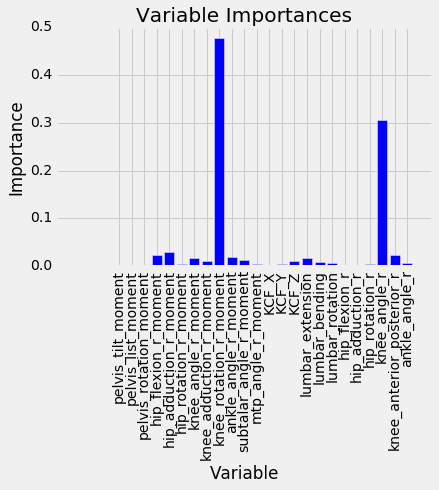

In [34]:
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical',align="center")
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

## Now we re-run the analysis with the first 6 most important features

In [35]:
low_features = []
for i in range(8,len(feature_importances)):
    low_features.append(feature_importances[i][0])


In [36]:
low_features.append('acl_r')

In [37]:
X = df.drop((low_features),axis=1)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [39]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 1000,
                           n_jobs = -1,
                           oob_score = True,
                           bootstrap = True,
                           random_state = 42)
rf.fit(X_train, y_train)
print('R^2 Training Score: {:.2f} \nOOB Score: {:.2f} \nR^2 Validation Score: {:.2f}'.format(rf.score(X_train, y_train), 
                                                                                             rf.oob_score_,
                                                                                             rf.score(X_test, y_test)))

R^2 Training Score: 0.99 
OOB Score: 0.91 
R^2 Validation Score: 0.85


In [40]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_list = list(X.columns)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
print[('Variable: {:20} Importance: {} '.format(*pair)) for pair in feature_importances]

['Variable: knee_rotation_r_moment Importance: 0.48 ', 'Variable: knee_angle_r         Importance: 0.32 ', 'Variable: hip_flexion_r_moment Importance: 0.04 ', 'Variable: hip_adduction_r_moment Importance: 0.04 ', 'Variable: knee_angle_r_moment  Importance: 0.03 ', 'Variable: ankle_angle_r_moment Importance: 0.03 ', 'Variable: lumbar_extension     Importance: 0.03 ', 'Variable: knee_anterior_posterior_r Importance: 0.03 ']


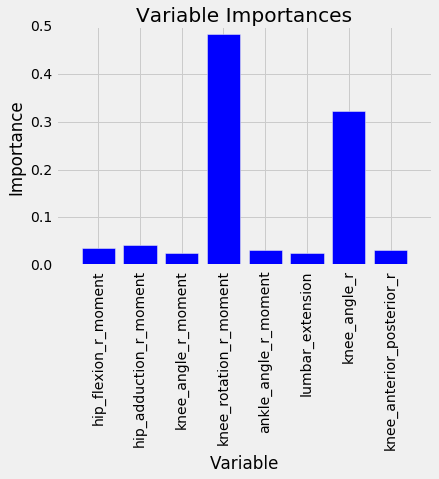

In [41]:
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical',align="center")
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

## Permutation importances tools - rfpimp

In [42]:
y = df['acl_r']
X = df.drop(['acl_r'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [57]:
rf = RandomForestRegressor(n_estimators = 100,
                           n_jobs = -1,
                           oob_score = True,
                           bootstrap = True,
                           random_state = 42)
rf.fit(X_train, y_train)
rf

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=True, random_state=42,
           verbose=0, warm_start=False)

In [44]:
from sklearn.metrics import r2_score
from rfpimp import permutation_importances

def r2(rf, X_train, y_train):
    return r2_score(y_train, rf.predict(X_train))

perm_imp_rfpimp = permutation_importances(rf, X_train, y_train, r2)

In [56]:
perm_imp_rfpimp.Importance


SyntaxError: invalid syntax (<ipython-input-56-6f30fb0c8f5a>, line 1)

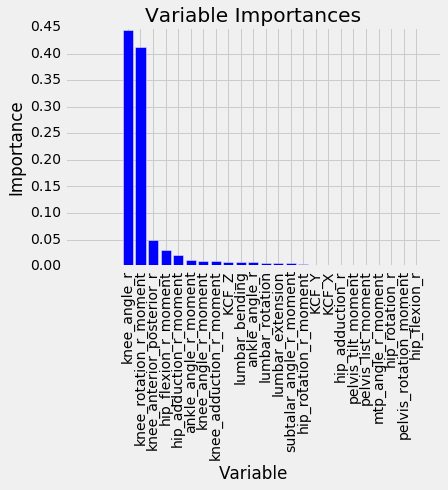

In [59]:
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(perm_imp_rfpimp)))
# Make a bar chart
plt.bar(x_values, perm_imp_rfpimp.Importance, orientation = 'vertical',align="center")
# Tick labels for x axis
plt.xticks(x_values, perm_imp_rfpimp.Importance.index, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');